In the previous notebook, we showed that current methodologies to calculate PAC are not flawless and include spurious PAC, caused by non-sinusoidal characteristics of signals, such as the overall waveform and/or sharp peaks and deflections in the signal. In this notebook, we show a methods to partly .............

# Load packages, modules and data

In [145]:
# import libraries
import os
import numpy as np
import scipy.io as sio
from scipy.signal import hilbert
import matplotlib.pyplot as plt



# import parts of bycycle 
from bycycle.filt import lowpass_filter
from bycycle.features import compute_features
from neurodsp import spectral
from fooof import FOOOF



#%% Change directory to import necessary modules
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')

#%% import self-defined modules
import module_load_data as load_data
import module_pac_functions as pacf
import module_detect_pac as detect_pac
import module_pac_plots as pac_plt

In [125]:
# load only one channel of a subject as example
subject = 'cc'
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')
dat_name = 'fixation_pwrlaw'

# Sampling Frequency
fs = 1000

# get the filename
sub_label = subject + '_base'
filename = os.path.join(os.getcwd(), dat_name, 'data', sub_label)

# load data
dataStruct = sio.loadmat(filename)

# get electrodes
elec_locs = dataStruct['locs']
data = dataStruct['data'][:,1]

# 1. Selecting Frequency Bands Using FOOOF

To calculate *meaningful* PAC, it is very imporant to select *meaningful* frequency bands. Therefore, instead of selecting a frequency band for the instantaneous phase with a fixed bandwidth beforehand, we look into the data first to see which which oscillations are actually present and with which bandwidth. For this step we use the 'Fitting Oscillations and One-Over-F (FoooF)'-package (Haller et al., 2018). This package takes aperiodic component of the power spectrum into account to calculate the relative oscillatory power. We will use a channel and its FOOOF parameters when the central frequency of the channel is under 15 Hz, and if the amplitude of the relative peak is at leas 0.2.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 55 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                          Background Parameters (offset, knee, slope):                            
                                     6.5225, 26.0421, 2.0833                                      
                                                                                                  
                                       3 peaks were found:                                        
          

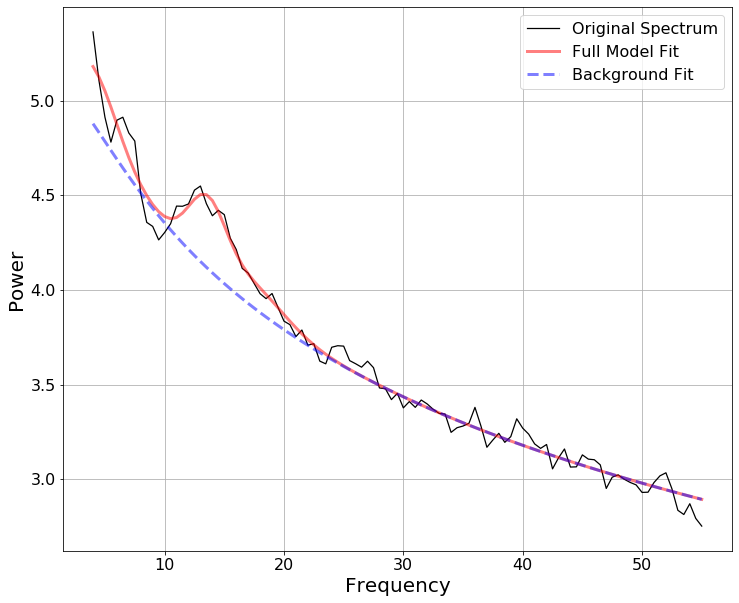

In [126]:
# get signal
sig = data

# compute frequency spectrum
freq_mean, psd_mean = spectral.compute_spectrum(sig, fs, method='welch', avg_type='mean', nperseg=fs*2)

# Set the frequency range upon which to fit FOOOF
freq_range = [4, 55]
bw_lims = [2, 8]
max_n_peaks = 4

# Initialize FOOOF model
fm = FOOOF(peak_width_limits=bw_lims, background_mode='knee', max_n_peaks=max_n_peaks)

# fit model
fm.fit(freq_mean, psd_mean, freq_range) 

# show report
fm.report()

In [127]:
# select biggest (highest amplitude) peak in spectrum
max_ampl_idx = np.argmax(fm.peak_params_[:,1])

# if the biggest central frequency is: 
# 1)     frequency <15 Hz (because we use this CF for the instantaneous phase)
# 2)     has an amplitude >.2 (so it is not a real small peak)
# 3)     has an amplitude <1.5 (higher seems artificial)
if ((fm.peak_params_[max_ampl_idx][0] < 15) &  \
    (fm.peak_params_[max_ampl_idx][1] >.2) &  \
    (fm.peak_params_[max_ampl_idx][1] < 1.5)): 

    # get Central Frequency, Amplitude, Bandwidth of this highest peak
    peak_params = fm.peak_params_[max_ampl_idx]

    # also get the offset, knee & slope of the aperiodic component, for later use
    background_params = fm.background_params_



# 2. Calculate the PAC's Rho value using Circle Correlation method


In [144]:
# define both amplitude and phase band
CF = peak_params[0]
BW = peak_params[2]

phase_providing_band= [(CF - (BW/2)),  (CF + (BW/2))]
amplitude_providing_band = [80, 125]

#calculating phase of theta
phase_data = pacf.butter_bandpass_filter(data, phase_providing_band[0], phase_providing_band[1], round(float(fs)));
phase_data_hilbert = hilbert(phase_data);
phase_data_angle = np.angle(phase_data_hilbert);

#calculating amplitude envelope of high gamma
amp_data = pacf.butter_bandpass_filter(data, amplitude_providing_band[0], amplitude_providing_band[1], round(float(fs)));
amp_data_hilbert = hilbert(amp_data);
amp_data_abs = abs(amp_data_hilbert);

PAC_values = pacf.circle_corr(phase_data_angle, amp_data_abs)

print('In this channel, there is significant PAC between the phase providing band and high-gamma')
print('')
print('The Rho-value of PAC is:                        ', PAC_values[0])
print('The P-value of PAC is:                          ', PAC_values[1])

rho_val = PAC_values[0]

In this channel, there is significant PAC between the phase providing band and high-gamma

The Rho-value of PAC is:                         0.012052005965197607
The P-value of PAC is:                           1.3859139458394232e-05


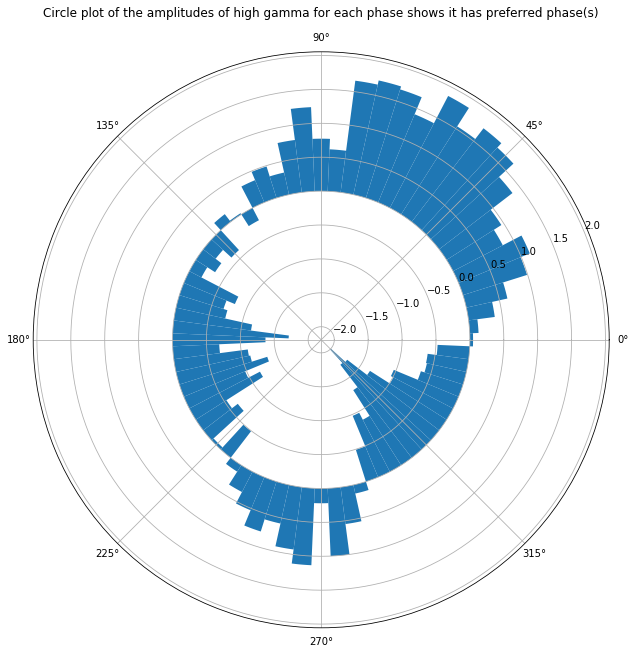

In [148]:
# show PAC with a plot
bin_size = 5; 
bins = range(-180,180+bin_size,bin_size); 
bins = np.dot(bins, 0.0174532925);

amps = [];

#filling phase bins with amplitudes
for x in range(len(bins)-1):
    # find the lower bound of the bin
    amps_above_lo_bound = np.where(phase_data_angle >= bins[x])[0];
    # find the higher bound of the bin
    amps_below_hi_bound = np.where(phase_data_angle < bins[x+1])[0];
    amps_below_hi_bound = set(amps_below_hi_bound);
    # select all samples that are within the range
    amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
    # find corresponding amplitudes for these samples
    amps_in_this_bin = amp_data_abs[amp_inds_in_this_bin];
    # calculate mean
    amps.append(np.mean(amps_in_this_bin));

bins = bins[:len(bins)-1];

#normalizing to make the effect more clear
amps = (amps-np.mean(amps))/np.std(amps);

#plotting figure;
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 1, 1], polar=True)
ax.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
plt.title('Circle plot of the amplitudes of high gamma for each phase shows it has preferred phase(s)');



# 3. Use Statistical Resampling to Find 'True' P- and Z-values

If we repeat this procedure for all subject and all their channels, we find significant PAC in over **90% of the channels**. This is way too high, and caused because current methodology finds significant numbers even in random data. To conclude whether there actually is PAC in a channel, we randomly shuffle the data 1000x and calculate the Rho value of PAC each time. Hereafter, we look if the *original Rho value we found significantly differs (p < .05) from Rho values found in the randomly shuffled (or 'rolled') data*. 

In [ ]:
# dont re-run, this can take a while (few minutes)

# number of resamples
num_resamples = 1000

# create array of random numbers between 0 and total samples 
# which is as long as the number of resamples
roll_array = np.random.randint(0, len(data), size=num_resamples)

# preallocate output space
resampled_rhovalues_sample = np.full(1000,np.nan)

# for every resample
for ii in range(len(roll_array)):

    # roll the phase data for a random amount 
    phase_data_roll = np.roll(data, roll_array[ii])

    #calculating phase of theta
    phase_data = pacf.butter_bandpass_filter(phase_data_roll, phase_providing_band[0], phase_providing_band[1], round(float(fs)));
    phase_data_hilbert = hilbert(phase_data);
    phase_data_angle = np.angle(phase_data_hilbert);

    #calculating amplitude envelope of high gamma
    amp_data = pacf.butter_bandpass_filter(data, amplitude_providing_band[0], amplitude_providing_band[1], round(float(fs)));
    amp_data_hilbert = hilbert(amp_data);
    amp_data_abs = abs(amp_data_hilbert);

    # calculate PAC
    PAC_values = pacf.circle_corr(phase_data_angle, amp_data_abs)
    
    # write rho value to output structure
    resampled_rhovalues_sample[ii] = PAC_values[0]

In [ ]:
plt.hist(resampled_rhovalues_sample)

true_z = (pac_rhos[subj][ch] - np.mean(resamp_rho[subj][ch])) / np.std(resamp_rho[subj][ch])
p_value = scipy.stats.norm.sf(abs(true_z))